In [17]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# data_path
data_dir = 'data'
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')
img_dir = os.path.join(data_dir, 'images')

# 训练数据和标签
train_df = pd.read_csv(train_csv)
print(train_df.head())

          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera


In [18]:
class LeafDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, train=True):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        if self.train:
            # 创建标签映射
            self.label_mapping = {label: idx for idx, label in enumerate(self.data_frame['label'].unique())}
            self.data_frame['label'] = self.data_frame['label'].map(self.label_mapping)
        else:
            self.data_frame['label'] = None

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.data_frame.iloc[idx, 1]
            label = torch.tensor(label, dtype=torch.long)
            return image, label
        else:
            return image, self.data_frame.iloc[idx, 0]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
# 加载训练数据集和数据加载器
train_dataset = LeafDataset(csv_file='data/train.csv', root_dir='data', transform=transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 加载测试数据集和数据加载器
test_dataset = LeafDataset(csv_file='data/test.csv', root_dir='data', transform=transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 加载模型和设置设备
weights = models.ResNet18_Weights.IMAGENET1K_V1  # 使用最新的权重枚举值
model = models.resnet18(weights=weights)
num_ftrs = model.fc.in_features
num_classes = len(train_dataset.label_mapping)  # 确保你知道有多少个类别
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


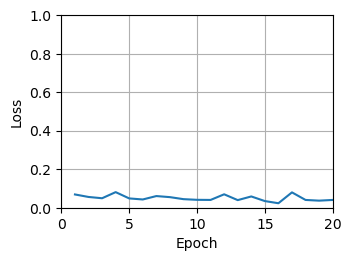

In [20]:
from animator import Animator

# 加载之前保存的模型权重
model.load_state_dict(torch.load('weights/resnet18_weights.pth'))


# 训练模型
num_epochs = 20

# 使用 Animator 动态绘图
animator = Animator(xlabel='Epoch', ylabel='Loss', xlim=[0, num_epochs], ylim=[0, 1])

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    # 添加损失到动画
    animator.add(epoch + 1, epoch_loss)
    
    # 保存模型权重
torch.save(model.state_dict(), 'weights/resnet18_weights.pth')


In [21]:
# 加载模型权重（在需要时）
model.load_state_dict(torch.load('weights/resnet18_weights.pth'))
model = model.to(device)

# 进行预测并生成提交文件
model.eval()
predictions = []

with torch.no_grad():
    for inputs, file_paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(zip(file_paths, preds.cpu().numpy()))

# 创建标签映射的反向字典
reverse_label_mapping = {v: k for k, v in train_dataset.label_mapping.items()}

# 根据预测结果生成提交文件
submission = pd.DataFrame(predictions, columns=['image', 'label'])
submission['label'] = submission['label'].map(reverse_label_mapping)
submission.to_csv('submission_resnet18.csv', index=False)